(['#101418', '#b4c0cd'],
 [array([16.34209209, 20.84892537, 24.36637284]),
  array([180.60424352, 192.11985347, 205.22261614])])

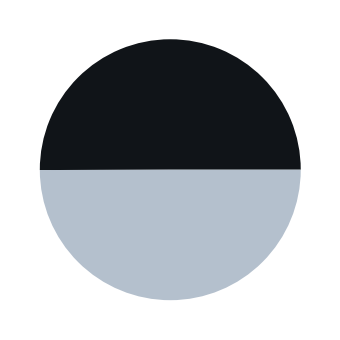

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import json

%matplotlib inline


def rgbToHex(color):
    """
   Converts RGB to HEX

   :param numpy.ndarray color: color that needs to be converted
   :return: HEX color code as string
   """
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))


def get_image(image_path):
    """
   Converts Image to RGB

   :param string image_path: path of the image
   :return: the image
   """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def get_colors(image, number_of_colors, show_chart):
    """
   Finds and shows colors from an image in HEX and RGB

   :param numpy.ndarray image: image itself
   :param int number_of_colors: number of colors
   :param boolean show_chart: show chart
   :return: the HEX and RGB color codes
   """
    # resizing image to reduce run time
    modified_image = cv2.resize(
        image, (1000, 1000), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(
        modified_image.shape[0]*modified_image.shape[1], 3)

    # KMeans algorithm creates clusters of colors
    colorCluster = KMeans(n_clusters=number_of_colors)
    labels = colorCluster.fit_predict(modified_image)

    # counting number of labels
    counts = Counter(labels)
    center_colors = colorCluster.cluster_centers_

    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [rgbToHex(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    # showing pie chart
    if (show_chart):
        plt.figure(figsize=(8, 6))
        plt.pie(counts.values(), labels=hex_colors,
                colors=hex_colors, textprops={'color': "w"})

    # saving the HEX color codes in a json file
    with open('colors.json', 'w') as f:
        json.dump(hex_colors, f)

    return hex_colors, rgb_colors


get_colors(get_image('../img/backgroundPicture.jpg'), 2, True)
